In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Cropping2D, Lambda, Activation, Dropout
from keras.optimizers import Adam, Nadam
from keras.initializers import glorot_normal
from sklearn.utils import shuffle
import bisect

/home/freddy/apps/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
driving_log = pd.read_csv('data/driving_log.csv', names=['center','left','right','angle','throttle','brake','speed'])

In [3]:
center_left_right_angle = driving_log[['center', 'left', 'right', 'angle']]

In [4]:
def processFilename(filename):
  filename = filename.split('/')
  filename = 'data/{}/{}'.format(filename[-2], filename[-1])
  return filename
# enddef

In [5]:
image = plt.imread( processFilename(center_left_right_angle.iloc[0].center) )

In [6]:
image.shape

(160, 320, 3)

In [7]:
# this function reads the images into memory, it is not a scalable approach when there are too many images
def read_angles(driving_log):
  angles = []
  for row in driving_log.itertuples():
    angle = row.angle
    angles.append(angle)
  # end for
  return np.array(angles)
# end def

In [8]:
angles = read_angles(center_left_right_angle)

In [9]:
angles.shape

(4201,)

In [10]:
freq, boundaries = np.histogram(angles, bins=[-1.0, -0.4, -0.2, -0.1, -0.025, 0.025, 0.1, 0.2, 0.4, 1.0])

In [11]:
prob = freq / np.sum(freq)
prob = 1 - prob / np.max(prob)
for i in zip(boundaries, prob):
  print(i)

(-1.0, 1.0)
(-0.4, 0.8597922848664689)
(-0.2, 0.7129080118694362)
(-0.1, 0.3850148367952523)
(-0.025, 0.0)
(0.025, 0.4065281899109793)
(0.1, 0.6550445103857567)
(0.2, 0.870919881305638)
(0.4, 0.9933234421364985)


In [12]:
augmented_angles = []
for angle in angles:
  augmented_angles.append(angle)
  i = bisect.bisect_left(boundaries, -angle) - 1 # find angle in the boundaries
  if np.random.rand() <= prob[i]:
    augmented_angles.append(-angle)

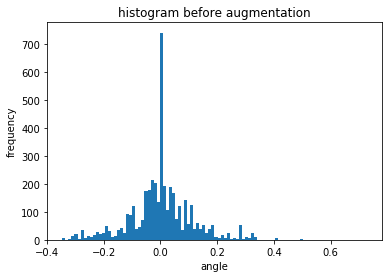

In [13]:
plt.hist(angles, bins=100)
plt.xlabel('angle')
plt.ylabel('frequency')
plt.title('histogram before augmentation')
plt.show()

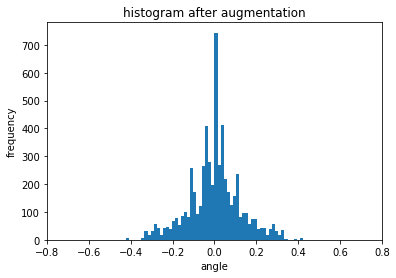

In [14]:
plt.hist(augmented_angles, bins=100)
plt.xlabel('angle')
plt.ylabel('frequency')
plt.title('histogram after augmentation')
plt.show()

In [15]:
np.random.seed(1) # set the random number seed

npts = len(center_left_right_angle)

# center_left_right_angle contains all the rows
# split into training and validation with a 0.8, 0.2 split

npts_rand = np.random.rand(npts)
train_set = center_left_right_angle[npts_rand <= 0.8]
valid_set = center_left_right_angle[npts_rand >  0.8]

In [16]:
def generator(data_set, batch_size):
  N = len(data_set)
  while True:
    data_set = shuffle(data_set)
    for offset in range(0, N, batch_size):
      rows = data_set.iloc[offset:offset+batch_size]
      images = []
      angles = []
      for row in rows.itertuples():
        angle = row.angle

        i = bisect.bisect_left(boundaries, -angle) - 1 # find angle in the boundaries
        if np.random.rand() <= prob[i]:
          augment = True
        else:
          augment = False
        
        # for center image
        image = plt.imread( processFilename(row.center) )
        images.append(image)
        angles.append(angle)
        if augment:
          images.append(cv2.flip(image, 1))
          angles.append(-angle)

        # for left image
        image = plt.imread( processFilename(row.left) )
        images.append(image)
        angles.append(angle + 0.2)
        if augment:
          images.append(cv2.flip(image, 1))
          angles.append(-angle - 0.2)
        

        # for right image
        image = plt.imread( processFilename(row.right) )
        images.append(image)
        angles.append(angle - 0.2)
        if augment:
          images.append(cv2.flip(image, 1))
          angles.append(-angle + 0.2)
        
      #end for
      images = np.array(images)
      angles = np.array(angles)
      
      yield shuffle(images, angles)
    #end for
  #end while
#end def 

In [17]:
batch_size = 16
train_generator = generator(train_set, batch_size)
valid_generator = generator(valid_set, batch_size)

steps_per_epoch  = np.rint(len(train_set) / batch_size).astype(int)
validation_steps = np.rint(len(valid_set) / batch_size).astype(int)

In [18]:
def nvidia():
  model = Sequential()
  model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3)))
  model.add(Cropping2D(cropping=((70,25), (0,0))))
  
  model.add(Conv2D(
    24, 5, strides=1, padding='valid', 
    kernel_initializer=glorot_normal(seed=1), bias_initializer='zeros'
  ))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(
    36, 5, strides=1, padding='valid',
    kernel_initializer=glorot_normal(seed=1), bias_initializer='zeros'
  ))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(
    48, 5, strides=1, padding='valid',
    kernel_initializer=glorot_normal(seed=1), bias_initializer='zeros'
  ))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(
    64, 3, padding='valid',
    kernel_initializer=glorot_normal(seed=1), bias_initializer='zeros'
  ))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Conv2D(
    64, 3, padding='valid',
    kernel_initializer=glorot_normal(seed=1), bias_initializer='zeros'
  ))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Flatten())

  model.add(Dense(100, kernel_initializer=glorot_normal(seed=1), bias_initializer='zeros'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Dense(50, kernel_initializer=glorot_normal(seed=1), bias_initializer='zeros'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Dense(10, kernel_initializer=glorot_normal(seed=1), bias_initializer='zeros'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  
  model.add(Dense(1, kernel_initializer=glorot_normal(seed=1), bias_initializer='zeros'))
  
  return model

In [19]:
model = nvidia()
optimizer = Adam(lr=1e-2)
model.compile(loss='mse', optimizer=optimizer)

In [ ]:
model.fit_generator(
  train_generator, steps_per_epoch=steps_per_epoch, 
  epochs=5, 
  validation_data=valid_generator, validation_steps=validation_steps
)

Epoch 1/5
210/210 [==============================] - 76s 360ms/step - loss: 0.0051 - val_loss: 0.0072
Epoch 2/5
210/210 [==============================] - 76s 364ms/step - loss: 0.0048 - val_loss: 0.0083
Epoch 3/5
210/210 [==============================] - 76s 363ms/step - loss: 0.0045 - val_loss: 0.0067
Epoch 4/5
210/210 [==============================] - 75s 358ms/step - loss: 0.0040 - val_loss: 0.0055
Epoch 5/5
161/210 [======================>.......] - ETA: 16s - loss: 0.0039

In [23]:
model.save('params/model.h5')
model.save_weights('params/model_weights.h5')

# json_string = model.to_json()
# with open('params/model_architecture.json', 'w') as fid:
#   fid.write(json_string)

In [ ]:
# this function reads the images into memory, it is not a scalable approach when there are too many images
def read_images(driving_log):
  images = []
  angles = []
  for row in driving_log.itertuples():
    angle = row.angle
    
    # for center image
    image = plt.imread( processFilename(row.center) )
    images.append(image)
    angles.append(angle)
    
    # for left image
    image = plt.imread( processFilename(row.left) )
    images.append(image)
    angles.append(angle + 0.2)
    
    # for right image
    image = plt.imread( processFilename(row.right) )
    images.append(image)
    angles.append(angle - 0.2)
    
    # end if
  # end for
  return np.array(images), np.array(angles)
# end def

In [ ]:
images, angles = read_images(center_left_right_angle)

In [ ]:
# augment the data set
augmented_images = []
augmented_angles = []
for image, angle in zip(images, angles):
  augmented_images.append(image)
  augmented_angles.append(angle)
  
  augmented_images.append(cv2.flip(image, 1))
  augmented_angles.append(-angle)
# end for

augmented_images = np.array(augmented_images)
augmented_angles = np.array(augmented_angles)

In [ ]:
mem_use = 4
for i in augmented_images.shape:
  mem_use *= i
print('memory use = gb', mem_use / np.power(2,30))

In [ ]:
plt.hist(augmented_angles, bins=100)
plt.xlabel('angle')
plt.ylabel('frequency')
plt.title('histogram after augmentation')
plt.show()

# as you can see, it is now normally distributed

In [ ]:
random_images = np.random.randint(0,images.shape[0],size=(3*3,))
# plot images in original RGB mode
plt.figure(figsize=(20,10))
for idx, i in enumerate(random_images):
  plt.subplot(3, 3, idx+1)
  plt.imshow(images[i,:,:,:])
  plt.title('{}. angle = {:.3g}'.format(idx, angles[i]))

In [ ]:
mu   = np.mean(augmented_images)
sigma = np.std(augmented_images)

In [ ]:
print('mu={}, sigma={}'.format(mu, sigma))

In [ ]:
augmented_images.shape

In [ ]:
model.fit(
  x=augmented_images, y=augmented_angles, 
  batch_size=200, epochs=5, verbose=1, validation_split=0.2, shuffle=True
)